# RNNs, CNNs, LSTMs - Sunspot Predictions
This notebook is an exploration to use a combination of LSTMs and a 1D CNN to predict sunspot activity. 

Data can be retrieved from: https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from os import getcwd
import csv

## Load and process data

In [2]:
# plot series function

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

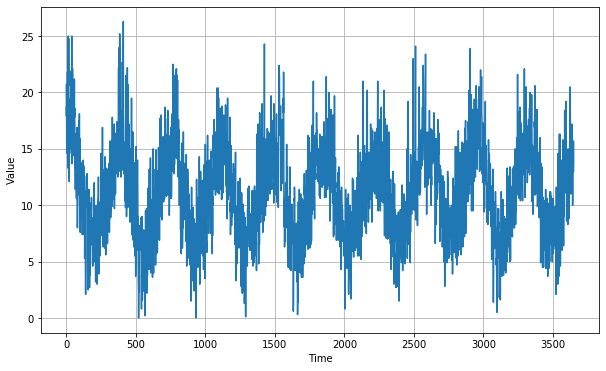

In [3]:
# load csv file 

time_step = []
temps = []

with open(getcwd() + '/data/daily-min-temperatures.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    step=0
    for row in reader:
        temps.append(float(row[1]))
        time_step.append(step)
        step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [4]:
# define train test split

split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
# define window size

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
# functions to create windowed dataset

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

## Model

In [7]:
# function to create forecast model predictions

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
# create windowed dataset

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [9]:
# model

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

In [10]:
# check for optimal learning rate

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 7s 680ms/step - loss: 31.1551 - mae: 31.6551
Epoch 2/100
10/10 [==============================] - 4s 368ms/step - loss: 30.5849 - mae: 31.0783
Epoch 3/100
10/10 [==============================] - 3s 346ms/step - loss: 29.6259 - mae: 30.1792
Epoch 4/100
10/10 [==============================] - 4s 368ms/step - loss: 28.5432 - mae: 29.0582
Epoch 5/100
10/10 [==============================] - 4s 376ms/step - loss: 27.2554 - mae: 27.6970
Epoch 6/100
10/10 [==============================] - 4s 356ms/step - loss: 25.4769 - mae: 25.9975
Epoch 7/100
10/10 [==============================] - 3s 327ms/step - loss: 23.3469 - mae: 23.8407
Epoch 8/100
10/10 [==============================] - 3s 344ms/step - loss: 20.5458 - mae: 21.1120
Epoch 9/100
10/10 [==============================] - 4s 361ms/step - loss: 17.2021 - mae: 17.8083
Epoch 10/100
10/10 [==============================] - 4s 361ms/step - loss: 13.5213 - mae: 14.1192
Epoch 11/100
10/10 

10/10 [==============================] - 4s 367ms/step - loss: 11.3032 - mae: 11.8899
Epoch 86/100
10/10 [==============================] - 4s 358ms/step - loss: 14.9811 - mae: 15.4639
Epoch 87/100
10/10 [==============================] - 3s 341ms/step - loss: 16.6007 - mae: 16.8665
Epoch 88/100
10/10 [==============================] - 3s 337ms/step - loss: 12.3333 - mae: 12.0340
Epoch 89/100
10/10 [==============================] - 3s 344ms/step - loss: 27.4619 - mae: 27.8160
Epoch 90/100
10/10 [==============================] - 4s 377ms/step - loss: 41.2526 - mae: 41.1429
Epoch 91/100
10/10 [==============================] - 3s 337ms/step - loss: 50.2967 - mae: 50.0934
Epoch 92/100
10/10 [==============================] - 4s 358ms/step - loss: 49.0436 - mae: 51.0028
Epoch 93/100
10/10 [==============================] - 4s 354ms/step - loss: 61.2518 - mae: 60.3589
Epoch 94/100
10/10 [==============================] - 4s 355ms/step - loss: 70.6147 - mae: 71.2435
Epoch 95/100
10/10 [===

[1e-08, 0.0001, 0, 60]

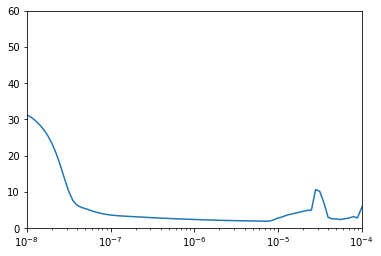

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

### Model with optimal learning rates

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 6s 253ms/step - loss: 9.9673 - mae: 10.5789
Epoch 2/150
25/25 [==============================] - 3s 130ms/step - loss: 2.5738 - mae: 3.0493
Epoch 3/150
25/25 [==============================] - 3s 134ms/step - loss: 1.9326 - mae: 2.3879
Epoch 4/150
25/25 [==============================] - 3s 122ms/step - loss: 1.8648 - mae: 2.3160
Epoch 5/150
25/25 [==============================] - 3s 126ms/step - loss: 1.8189 - mae: 2.2715
Epoch 6/150
25/25 [==============================] - 3s 125ms/step - loss: 1.7909 - mae: 2.2419
Epoch 7/150
25/25 [==============================] - 3s 130ms/step - loss: 1.7628 - mae: 2.2129
Epoch 8/150
25/25 [==============================] - 3s 120ms/step - loss: 1.7430 - mae: 2.1939
Epoch 9/150
25/25 [==============================] - 3s 130ms/step - loss: 1.7179 - mae: 2.1688
Epoch 10/150
25/25 [==============================] - 3s 126ms/step - loss: 1.6983 - mae: 2.1483
Epoch 11/150
25/25 [==================

25/25 [==============================] - 3s 123ms/step - loss: 1.5039 - mae: 1.9470
Epoch 86/150
25/25 [==============================] - 3s 132ms/step - loss: 1.5032 - mae: 1.9453
Epoch 87/150
25/25 [==============================] - 3s 126ms/step - loss: 1.5026 - mae: 1.9444
Epoch 88/150
25/25 [==============================] - 3s 128ms/step - loss: 1.5039 - mae: 1.9452
Epoch 89/150
25/25 [==============================] - 3s 125ms/step - loss: 1.5001 - mae: 1.9432
Epoch 90/150
25/25 [==============================] - 3s 131ms/step - loss: 1.5019 - mae: 1.9426
Epoch 91/150
25/25 [==============================] - 3s 129ms/step - loss: 1.5014 - mae: 1.9440
Epoch 92/150
25/25 [==============================] - 3s 124ms/step - loss: 1.5008 - mae: 1.9430
Epoch 93/150
25/25 [==============================] - 3s 125ms/step - loss: 1.4979 - mae: 1.9402
Epoch 94/150
25/25 [==============================] - 3s 132ms/step - loss: 1.4972 - mae: 1.9391
Epoch 95/150
25/25 [=======================

In [13]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

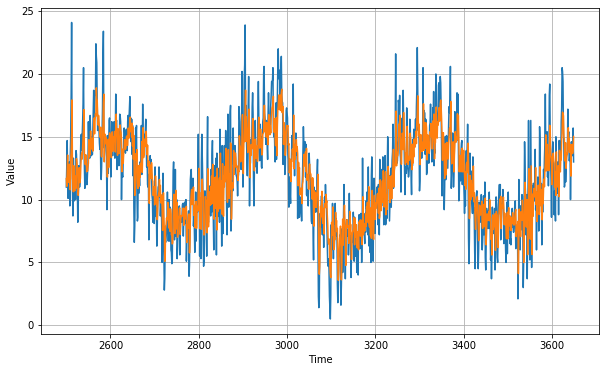

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.7813919